# Plot the outcomes of individual test sites

In [45]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import itertools as it

rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 14

# soil layer depths in ELM
zsoi = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 2.8646])
zisoi = np.array([0.0175, 0.0451, 0.0906, 0.1655, 0.2891, 0.4929, 0.8289, 1.3828, 2.2961, 3.8019])
dzsoi = np.array([0.0175, 0.0276, 0.0455, 0.0750, 0.1236, 0.2038, 0.3360, 0.5539, 0.9133, 1.5058])

# major cation list
cations = ['Ca2+','Mg2+','Na+','K+','Al3+']

# list of NetCDF file names generated by ELM
date_prefix = '20241009'
region = 'ERWSites'
#case_suffix = 'ICB1850CNPRDCTCBC_erw'
#start = 2
#end = 40
start = 1850 # pre-1920 met forcing are not reliable; just focus on more recent periods
end = 2009
case_suffix = 'ICB20TRCNPRDCTCBC_50year_twined_erw'

if '1850CN' in case_suffix:
    tvec = pd.date_range(f'{start+2000}-01-01', f'{end+2000}-12-31', freq = '1D')
    tvec_mon = pd.date_range(f'{start+2000}-01-01', f'{end+2000}-12-31', freq = '1MS')
    tvec_yr = pd.date_range(f'{start+2000}-01-01', f'{end+2000}-12-31', freq = '1YS')
else:
    tvec = pd.date_range(f'{start}-01-01', f'{end}-12-31', freq = '1D')
    tvec_mon = pd.date_range(f'{start}-01-01', f'{end}-12-31', freq = '1MS')
    tvec_yr = pd.date_range(f'{start}-01-01', f'{end}-12-31', freq = '1YS')
tvec = tvec[(tvec.month != 2) | (tvec.day != 29)]
case_name = f'{date_prefix}_{region}_{case_suffix}'
file_list = [os.path.join(os.environ['E3SM_ROOT'], 'output', case_name, 'run', 
                          f'{case_name}.elm.h1.{year:04d}-01-01-00000.nc') \
             for year in range(start, end + 1)]

# path to save the graphs
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'plot_ERWsites', case_name)
if not os.path.exists(path_out):
    os.mkdir(os.path.join(path_out))

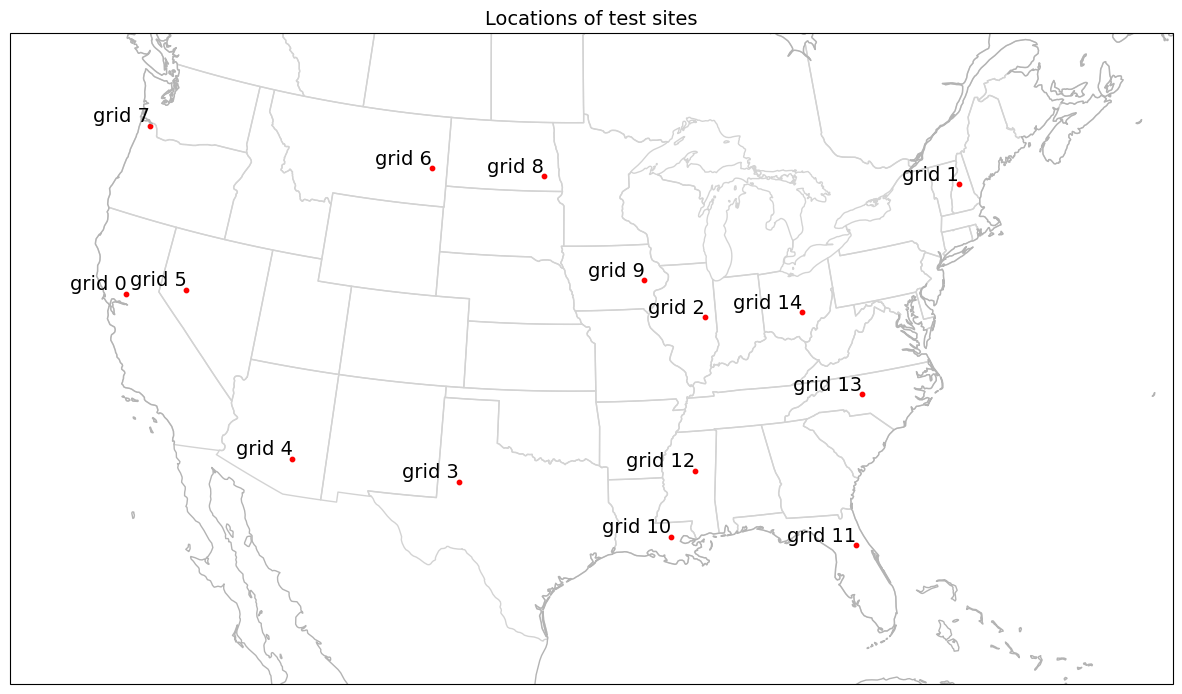

<Figure size 640x480 with 0 Axes>

In [46]:
path_domain = os.path.join(os.environ['E3SM_ROOT'], 'output', case_name, 'run', 'domain.nc')

hr = xr.open_dataset(path_domain)

site_lons = hr['xc'].values[0, :] - 360
site_lats = hr['yc'].values[0, :]
site_list = [f'grid {i}' for i in range(len(site_lons))]

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.LambertConformal()})
ax.add_feature(cfeature.STATES, edgecolor='lightgrey', facecolor='none')
ax.add_feature(cfeature.COASTLINE, edgecolor=(0.7, 0.7, 0.7), facecolor='none')
ax.set_extent([-123, -67, 24, 50], crs=ccrs.PlateCarree())
ax.scatter(site_lons, site_lats, facecolor = 'r', transform=ccrs.PlateCarree(), s = 10)
for i in range(len(site_lons)):
    ax.text(site_lons[i], site_lats[i], f'grid {i}', transform=ccrs.PlateCarree(),
            horizontalalignment = 'right', verticalalignment = 'bottom')
plt.title('Locations of test sites')
plt.show()
plt.savefig(os.path.join(path_out, 'location_of_test_sites.png'), dpi = 600., bbox_inches = 'tight')
#plt.close()

# 1. Hydrological balance

In [47]:
hr = xr.open_mfdataset(file_list)

# annual mean variables - mm/year
hydro = pd.DataFrame(np.nan, index = site_list, 
                     columns = ['P', 'ET', 'QOVER', 'QDRAI'])
hydro.loc[:, 'P'] = (hr['RAIN'].values + hr['SNOW'].values).mean(axis = 0) * 86400 * 365
hydro.loc[:, 'ET'] = (hr['QVEGE'].values + hr['QVEGT'].values + hr['QSOIL'].values
                     ).mean(axis = 0) * 86400 * 365
hydro.loc[:, 'QOVER'] = hr['QOVER'].mean(axis = 0).values * 86400 * 365
hydro.loc[:, 'QDRAI'] = hr['QDRAI'].mean(axis = 0).values * 86400 * 365

# VWC 
vwc = pd.DataFrame(np.nan, columns = site_list,
                   index = pd.MultiIndex.from_product([range(1,13),range(1,11)]))
vwc.loc[:, :] = np.transpose(hr['H2OSOI'].groupby('time.month').mean()[:, :10, :].values, 
                             axes = [0, 2, 1]).reshape(-1, len(site_list))

# QDRAI time series - mm/year
qdrai = pd.DataFrame(np.nan, columns = site_list, index = range(start, end + 1))
qdrai.loc[:, :] = hr['QDRAI'].resample(time = '1Y').mean().values * 86400 * 365

hr.close()

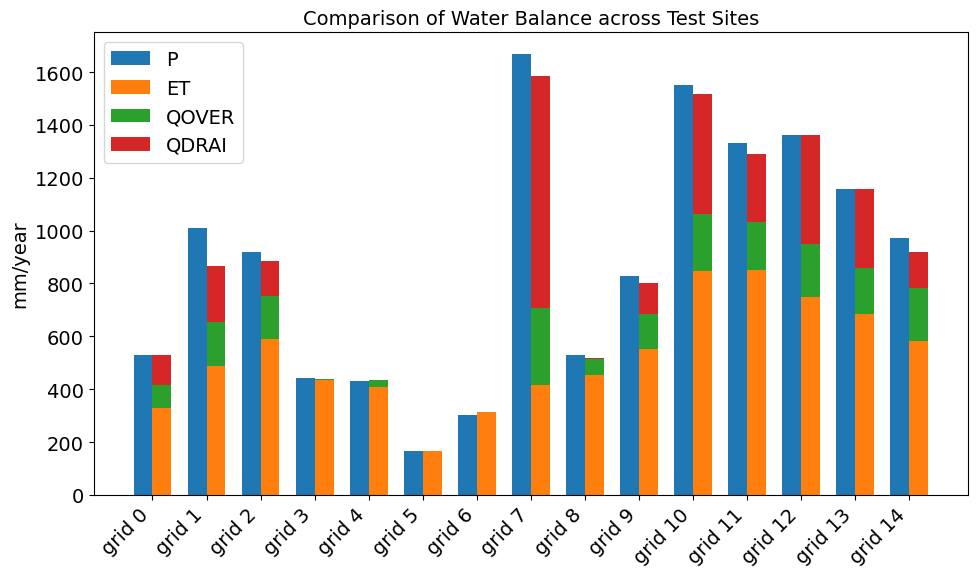

<Figure size 640x480 with 0 Axes>

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = range(len(hydro))

p1 = ax.bar(ind, hydro['P'], width, label='P')
p2 = ax.bar([i + width for i in ind], hydro['ET'], width, label='ET')
p3 = ax.bar([i + width for i in ind], hydro['QOVER'], width, bottom=hydro['ET'], label='QOVER')
p4 = ax.bar([i + width for i in ind], hydro['QDRAI'], width, bottom=hydro['ET'] + hydro['QOVER'],
            label='QDRAI')

ax.set_ylabel('mm/year')
ax.set_title('Comparison of Water Balance across Test Sites')
ax.set_xticks([i + width/2 for i in ind])
ax.set_xticklabels(hydro.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

plt.savefig(os.path.join(path_out, 'compare_water_balance.png'), dpi = 600., bbox_inches = 'tight')

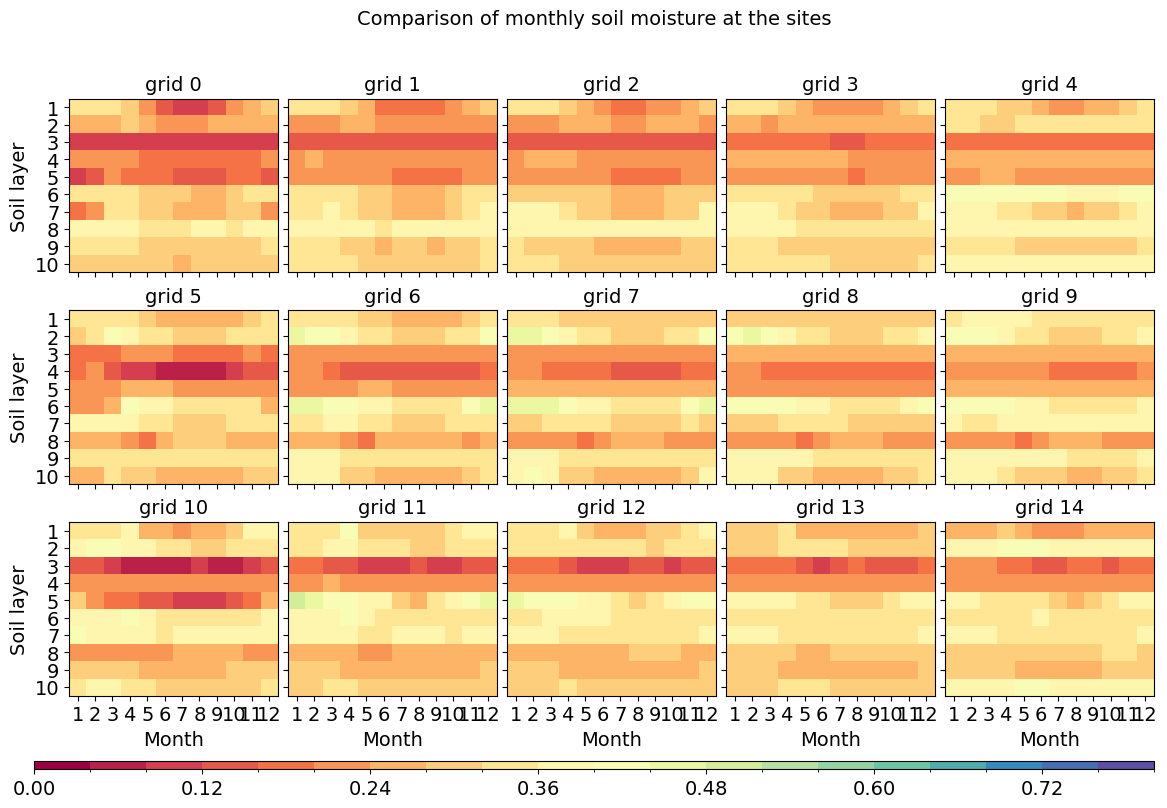

In [49]:
norm = BoundaryNorm(np.linspace(0, 0.8, 21), ncolors = 256, clip = True)

clist = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5',
         '#80cdc1', '#35978f', '#01665e', '#003c30']
fig, axes = plt.subplots(3, 5, figsize = (14, 8), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)
for i, site in enumerate(site_list):
    ax = axes.flat[i]
    cf = ax.imshow(vwc[site].unstack().values.T, norm = norm, cmap = 'Spectral')
    ax.set_title(site)
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1,13))
    ax.set_yticks(range(10))
    ax.set_yticklabels(range(1,11))
    if np.mod(i, 5) == 0:
        ax.set_ylabel('Soil layer')
    if i >= 10:
        ax.set_xlabel('Month')
cax = fig.add_axes([0.1, 0.03, 0.8, 0.01])
plt.colorbar(cf, cax = cax, orientation = 'horizontal')
fig.suptitle('Comparison of monthly soil moisture at the sites', fontsize = 14)

plt.savefig(os.path.join(path_out, 'compare_vwc.png'), dpi = 600., bbox_inches = 'tight')

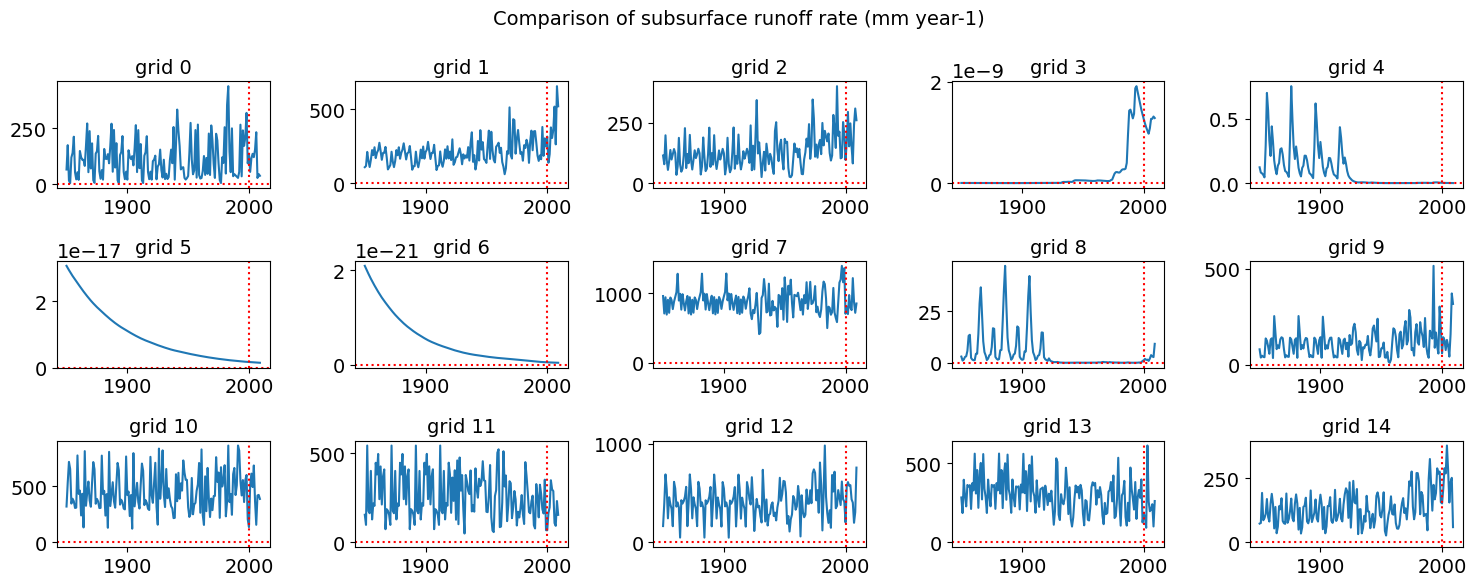

In [50]:
# QDRAI time series
fig, axes = plt.subplots(3, 5, figsize = (15, 6))
for i, site in enumerate(site_list):
    ax = axes.flat[i]
    ax.plot(qdrai.index, qdrai[site])
    ax.set_title(site)
    ax.axhline(0, color = 'r', ls = ':')
    ax.axvline(2000, color = 'r', ls = ':')
fig.suptitle('Comparison of subsurface runoff rate (mm year-1)', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_out, 'compare_qdrai.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

# 2. Cation balance

## 2.1 Target variable: `r_sequestration`

Direct subtraction of background weathering rate is not good practice.

Need to subtract from just control run.

In [51]:
# gC m-2 s-1 => ton ha-1 yr-1
r_sequestration = pd.DataFrame(np.nan, columns = site_list, index = range(start, end + 1))
hr = xr.open_mfdataset(file_list)
r_sequestration.loc[:, :] = hr['r_sequestration'].resample(time = '1Y').mean().values  \
        * 86400 * 365 / 100
hr.close()

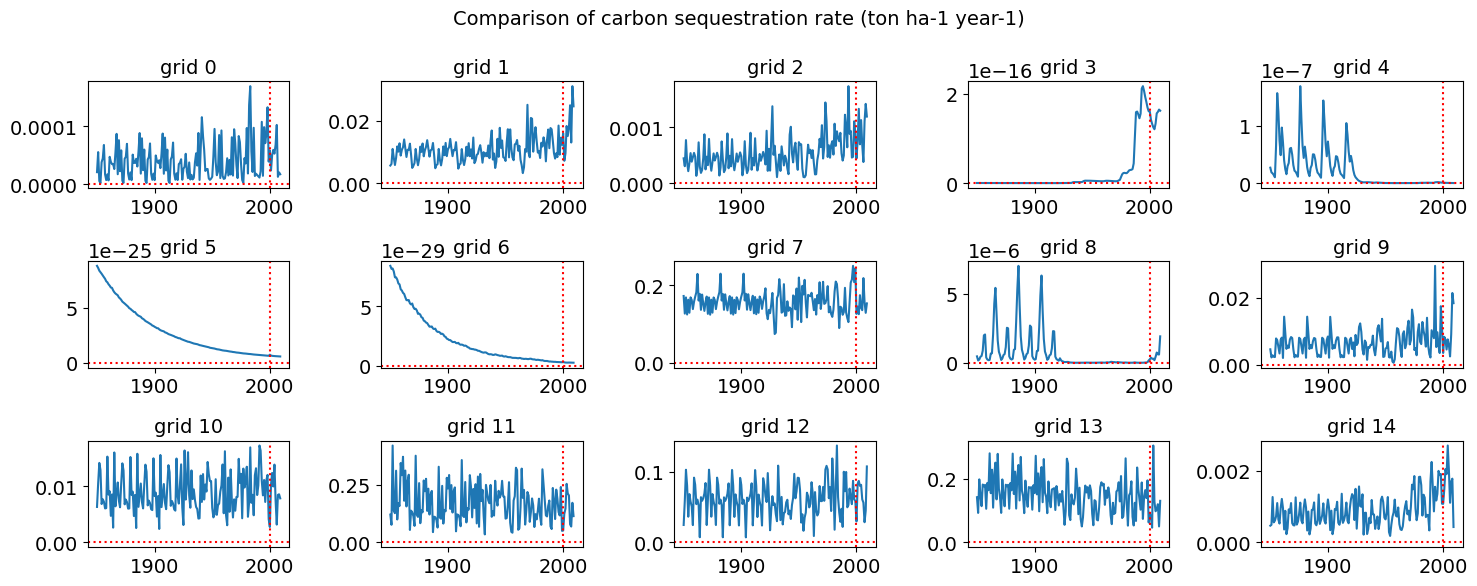

In [52]:
fig, axes = plt.subplots(3, 5, figsize = (15, 6))
for i, site in enumerate(site_list):
    ax = axes.flat[i]
    ax.plot(r_sequestration.index, r_sequestration[site])
    ax.set_title(site)
    ax.axhline(0, color = 'r', ls = ':')
    ax.axvline(2000, color = 'r', ls = ':')
fig.suptitle('Comparison of carbon sequestration rate (ton ha-1 year-1)', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_out, 'compare_r_sequestration.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

## 2.2 Primary mineral dissolution

Integrated over all the layers (primary mineral only exists until mixing depth - the top six layers)

In [53]:
minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
# normal alkali basalt (fast)
# pct_basalt = np.array([0, 12, 0, 0, 0, 0, 43, 21, 6, 0])

# ! Need to correct: the other three are not saved! 
mineral_list = [2, 7, 8, 9]

In [54]:
# g Rock m-2 => ton ha-1
# Resample using "max()" to get the start value in each month
primary_mineral = pd.DataFrame(np.nan, 
    index = pd.date_range('1999-01-01', f'{end}-12-31', freq='1MS'),
    columns = pd.MultiIndex.from_product([mineral_list, site_list]))
hr = xr.open_mfdataset(file_list)
for min,site in it.product(mineral_list, site_list):
    temp = hr[f'primary_mineral_vr_{min}'][hr['time'].to_index().year >= 1999, :10, 
                                           :].resample(time = '1M').max().values/100
    temp = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1)
    primary_mineral.loc[:, min] = temp
hr.close()

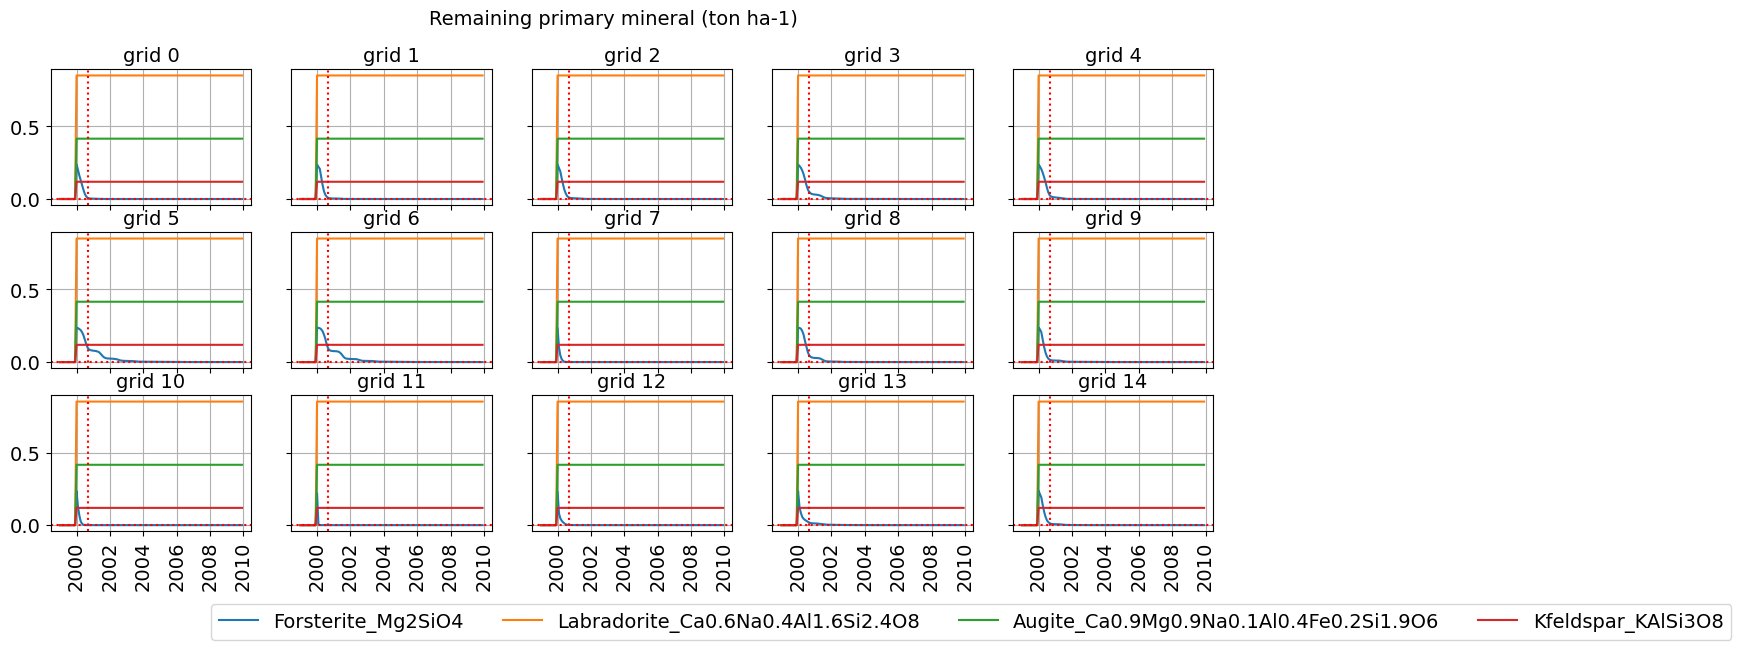

In [55]:
fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = True)
for i, site in enumerate(site_list):
    ax = axes.flat[i]
    h = []
    for min in mineral_list:
        temp, = ax.plot(primary_mineral.index, primary_mineral[(min,site)])
        h.append(temp)
    ax.set_title(site)
    ax.axhline(0, color = 'r', ls = ':')
    ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
    plt.setp(ax.get_xticklabels(), rotation = 90)
    ax.grid(True)
ax.legend(h, [minerals_name[i-1] for i in mineral_list], ncol = len(mineral_list), loc = (-4, -0.8))
fig.suptitle('Remaining primary mineral (ton ha-1)', fontsize = 14)
plt.savefig(os.path.join(path_out, 'compare_primary_mineral_state.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

## 2.3. Cation states: pH, cation concentration, CEC H+ and cations

Integrate to two levels: mixing depth and all soil layers

In [56]:
cation_mass = [40, 24, 39, 23, 27]
cation_valence = [2, 2, 1, 1, 3]
mixing_layer = 5

In [57]:
# soil pH
soil_pH = pd.DataFrame(np.nan, index = tvec_mon,
    columns = pd.MultiIndex.from_product([['mixing_depth','full_depth'], site_list]))
hr = xr.open_mfdataset(file_list)

temp = hr['soil_pH'][:, :10, :].resample(time = '1M').mean().values

temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
soil_pH.loc[:, 'full_depth'] = temp1

temp2 = np.sum(temp[:, :mixing_layer, :] * \
        dzsoi[:mixing_layer].reshape(1, -1, 1), axis = 1) / \
        np.sum(dzsoi[:mixing_layer])
soil_pH.loc[:, 'mixing_depth'] = temp2

hr.close()

In [58]:
# cation concentration in soil solution, g m-3 => mol kg-1
soil_cation = pd.DataFrame(np.nan, tvec_mon,
    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'], 
                                          site_list]))
hr = xr.open_mfdataset(file_list)
for i in range(len(cations)):
    temp = hr[f'cation_vr_{i+1}'][:,:10,:] / cation_mass[i] / hr['H2OSOI'].values[:,:10,:] / 1000.
    temp = temp.resample(time = '1M').mean().values

    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
    soil_cation.loc[:, (cations[i],'full_depth')] = temp1

    temp2 = np.sum(temp[:, :mixing_layer] * \
        dzsoi[:mixing_layer].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:mixing_layer])
    soil_cation.loc[:, (cations[i],'mixing_depth')] = temp2
hr.close()

/tmp/ipykernel_1323541/3287574227.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  soil_cation.loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3287574227.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  soil_cation.loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/3287574227.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  soil_cation.loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3287574227.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  soil_cation.loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/3287574227.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  soil_cation.loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3287574227.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  soil_cation.loc[:, (cations[i],'mixi

In [59]:
# CEC H+, g m-3 => meq 100g-1 soil
cec_proton = pd.DataFrame(np.nan, index = tvec_mon,
    columns = pd.MultiIndex.from_product([['mixing_depth','full_depth'], site_list]))
hr = xr.open_mfdataset(file_list)

temp = hr['cec_proton_vr'][:,:10,:] * 100 / hr['bd_col'][:,:10, :]
temp = temp.resample(time = '1M').mean().values

temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
cec_proton.loc[:, 'full_depth'] = temp1
temp2 = np.sum(temp[:, :mixing_layer] * \
    dzsoi[:mixing_layer].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:mixing_layer])
cec_proton.loc[:, 'mixing_depth'] = temp2

hr.close()

In [60]:
# CEC cations, g m-3 => meq 100g-1 soil
cec_cation = pd.DataFrame(np.nan, index = tvec_mon,
    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'], site_list]))
hr = xr.open_mfdataset(file_list)
for i in range(len(cations)):
    temp = hr[f'cec_cation_vr_{i+1}'][:, :10, :] * 100 / hr['bd_col'][:,:10, :] * \
        cation_valence[i] / cation_mass[i]
    temp = temp.resample(time = '1M').mean().values

    temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
    cec_cation.loc[:, (cations[i],'full_depth')] = temp1
    temp2 = np.sum(temp[:, :mixing_layer] * \
            dzsoi[:mixing_layer].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:mixing_layer])
    cec_cation.loc[:, (cations[i],'mixing_depth')] = temp2
hr.close()

/tmp/ipykernel_1323541/187200865.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  cec_cation.loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/187200865.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  cec_cation.loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/187200865.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  cec_cation.loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/187200865.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  cec_cation.loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/187200865.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  cec_cation.loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/187200865.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  cec_cation.loc[:, (cations[i],'mixing_depth')] 

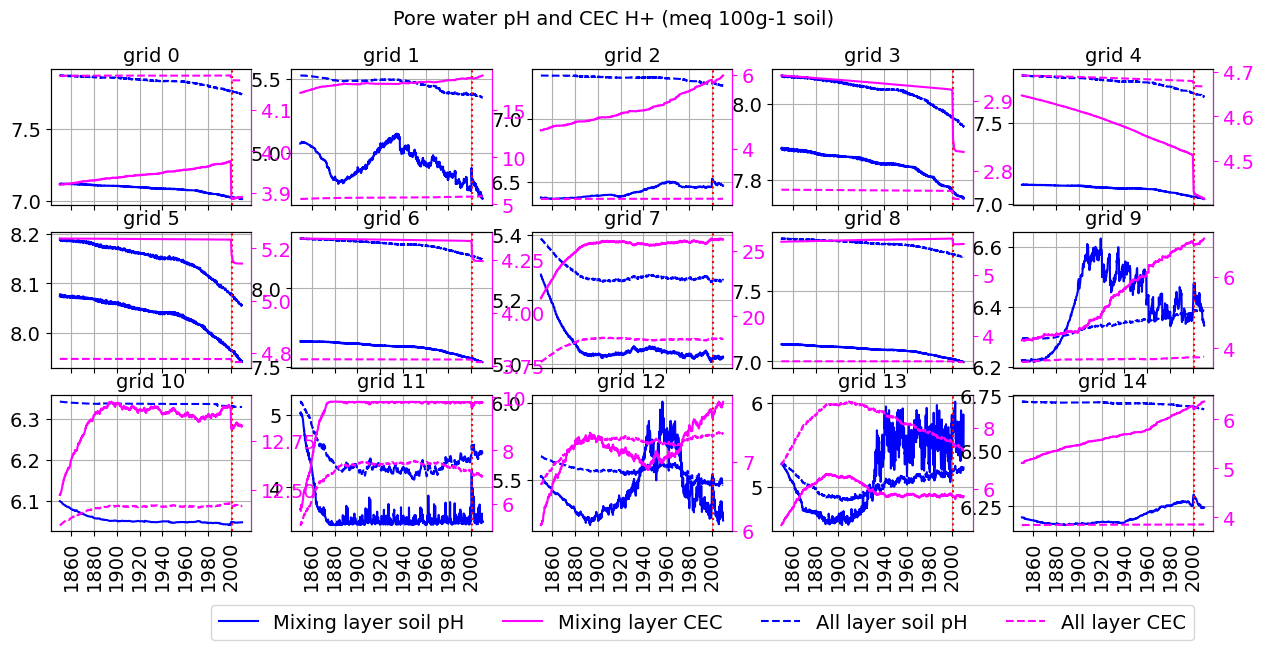

In [61]:
# plot soil pH and CEC H+ on the same graph

fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = False)
for i, site in enumerate(site_list):
    ax = axes.flat[i]
    ax2 = ax.twinx()

    h = []
    for layer, ls in zip(['mixing_depth', 'full_depth'], ['-', '--']):
        htemp, = ax.plot(soil_pH.index, soil_pH[(layer, site)], color = 'b', ls = ls)
        h.append(htemp)
        htemp, = ax2.plot(cec_proton.index, cec_proton[(layer, site)], color = 'magenta', ls = ls)
        h.append(htemp)

    ax.set_title(site)
    ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
    plt.setp(ax.get_xticklabels(), rotation = 90)
    # ax.set_yticks(np.arange(1, 8.1, 1))
    ax.grid(True)
    # ax.set_xlim([pd.Timestamp('1999-01-01'), pd.Timestamp('2007-12-31')])

    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.spines['right'].set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    # ax2.set_ylim([2, 15])

ax.legend(h, ['Mixing layer soil pH','Mixing layer CEC','All layer soil pH','All layer CEC'],
          loc = [-4, -0.8], ncol = 4)
fig.suptitle('Pore water pH and CEC H+ (meq 100g-1 soil)', fontsize = 14)
plt.savefig(os.path.join(path_out, 'compare_proton_state.png'), 
            dpi = 600., bbox_inches = 'tight')
#plt.close()

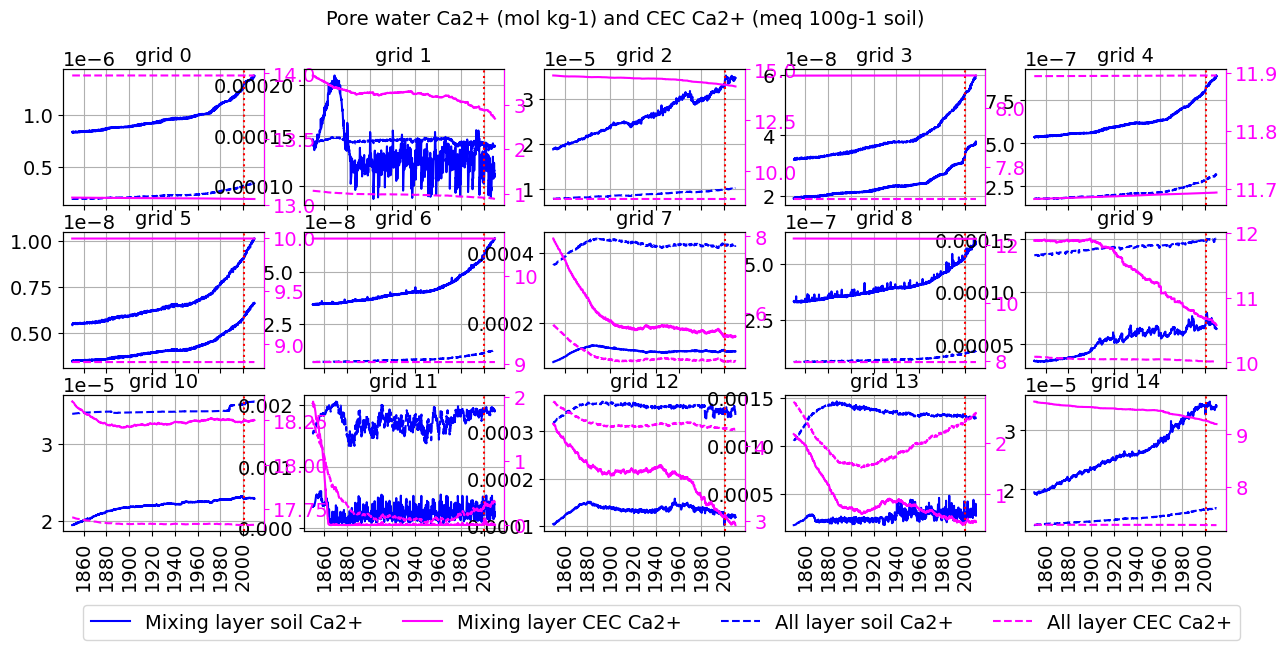

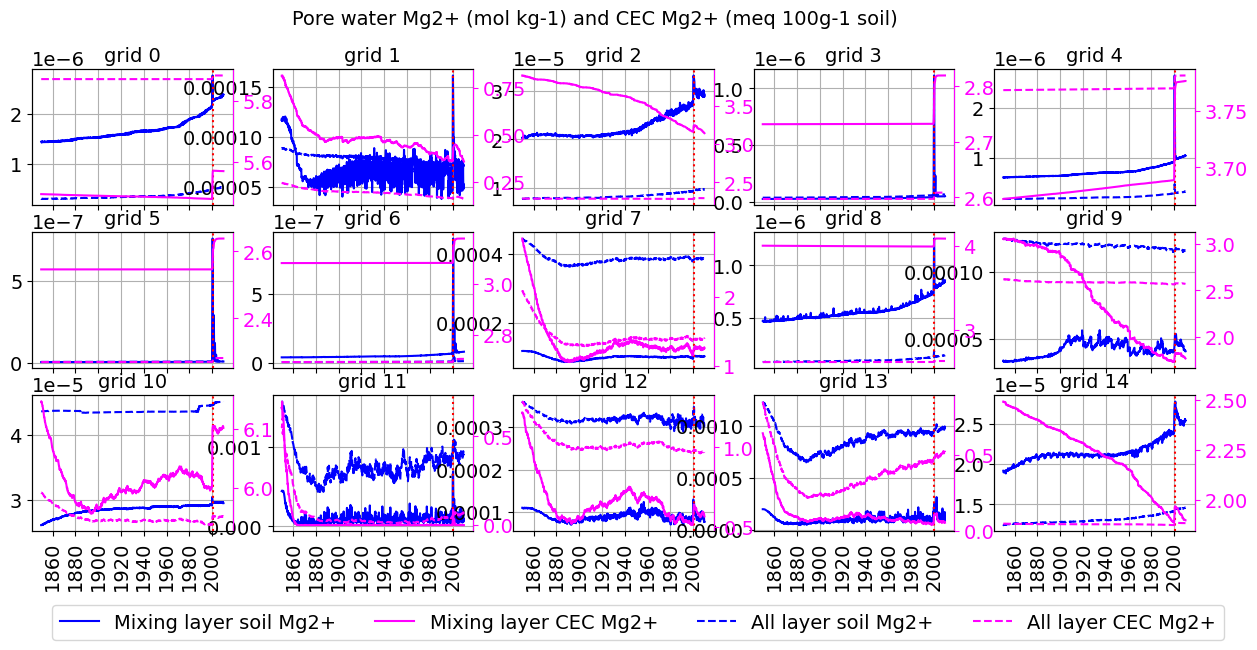

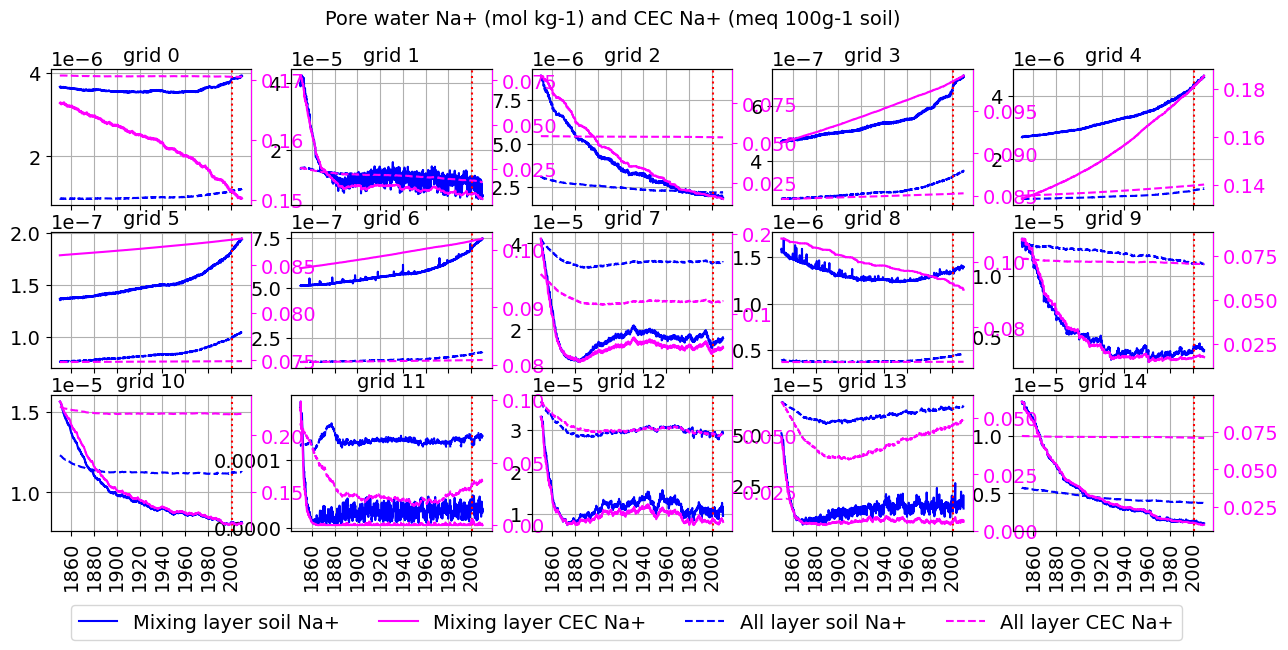

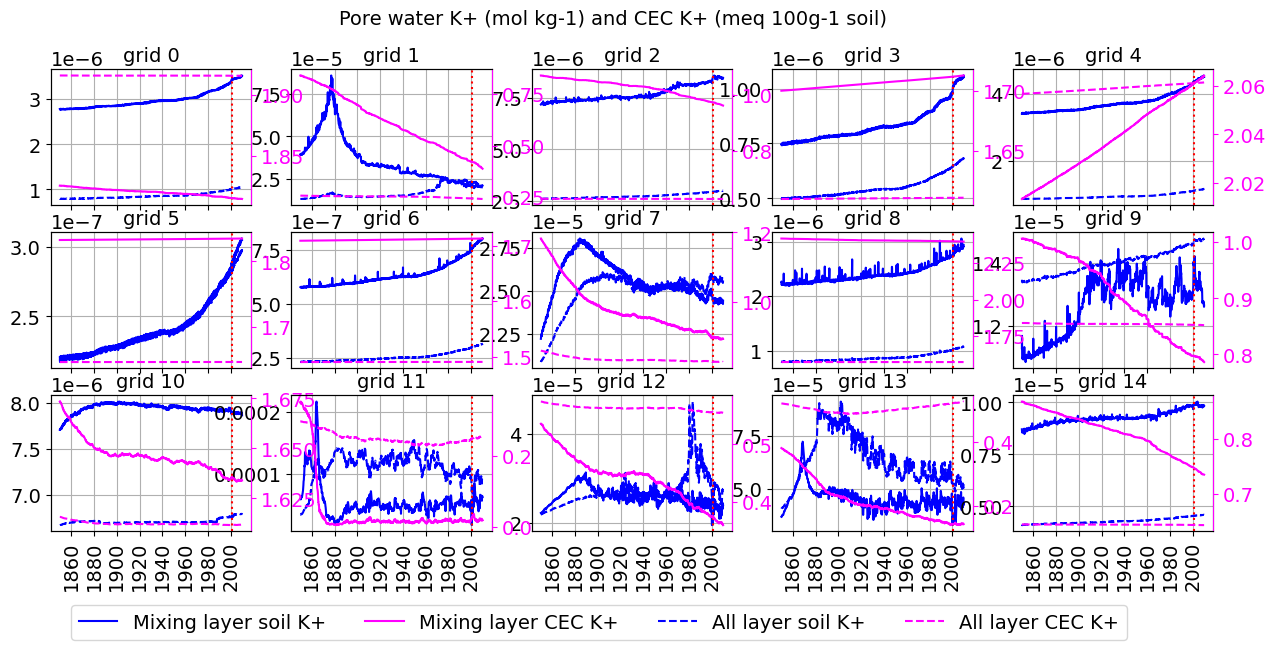

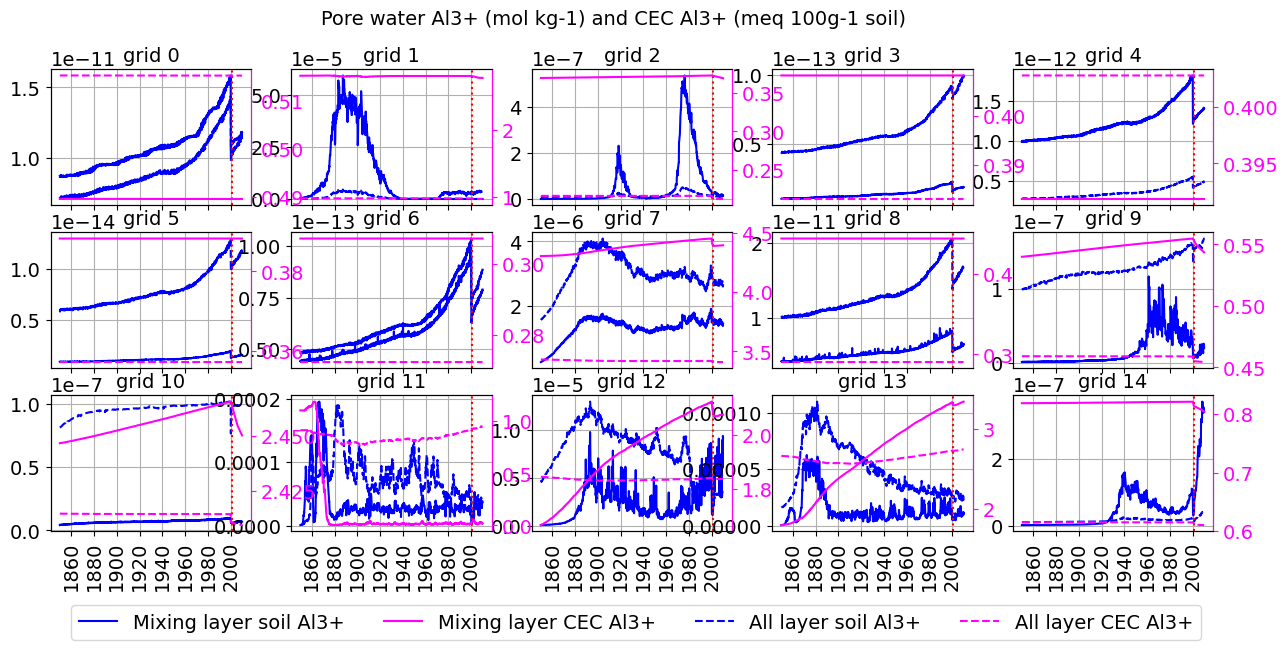

In [62]:
# plot soil pore water cation and CEC cation on the same graph
for icat,ion in enumerate(cations):
    fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = False)
    for i, site in enumerate(site_list):
        ax = axes.flat[i]
        ax2 = ax.twinx()

        h = []
        for layer, ls in zip(['mixing_depth', 'full_depth'], ['-', '--']):
            htemp, = ax.plot(soil_cation.index, soil_cation[(ion,layer,site)], color = 'b', ls = ls)
            h.append(htemp)
            htemp, = ax2.plot(cec_cation.index, cec_cation[(ion,layer,site)], 
                              color = 'magenta', ls = ls)
            h.append(htemp)

        ax.set_title(site)
        ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
        plt.setp(ax.get_xticklabels(), rotation = 90)
        ax.grid(True)
        # ax.set_yscale('log')
        # ax.set_xlim([pd.Timestamp('1999-01-01'), pd.Timestamp('2007-12-31')])

        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
        ax2.spines['right'].set_color('magenta')
        ax2.tick_params(axis='y', colors='magenta')

    ax.legend(h, [f'Mixing layer soil {ion}', f'Mixing layer CEC {ion}',
                  f'All layer soil {ion}', f'All layer CEC {ion}'],
            loc = [-4.7, -0.8], ncol = 4)
    fig.suptitle(f'Pore water {ion} (mol kg-1) and CEC {ion} (meq 100g-1 soil)', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_cation_state_{icat}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

## 2.4 Cation dynamics

 background weathering
 
 primary cation flux
 
 CEC cation flux
 
 secondary cation flux
 
 cation_infl_vr
 
 cation_leached_vr
 
 cation_runoff_vr

In [63]:
# background weathering rate, g m-3
flux_dict = {}
for var in ['background_flux', 'background_cec', 'annavg_cec_delta']:
    flux_dict[var] = \
        pd.DataFrame(np.nan, index = tvec_mon,
                    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'],
                                                        site_list]))
hr = xr.open_mfdataset(file_list)
for i in range(len(cations)):
    for var in flux_dict.keys():
        temp = hr[f'{var}_vr_{i+1}'][:, :10, :].resample(time = '1M').mean().values

        temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
        flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1

        temp2 = np.sum(temp[:, :6] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
        flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
hr.close()

/tmp/ipykernel_1323541/694950347.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/694950347.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/694950347.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/694950347.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2


/tmp/ipykernel_1323541/694950347.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/694950347.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/694950347.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/694950347.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/694950347.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/694950347.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cati

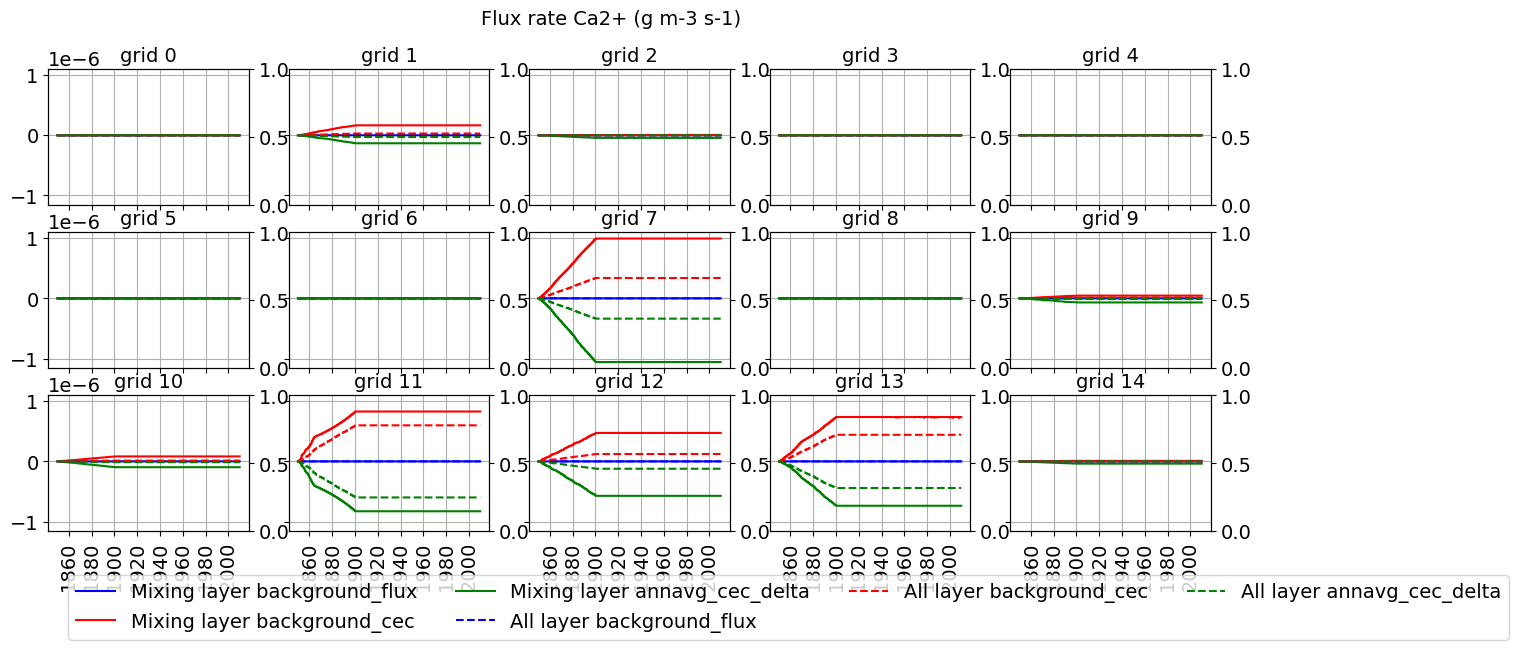

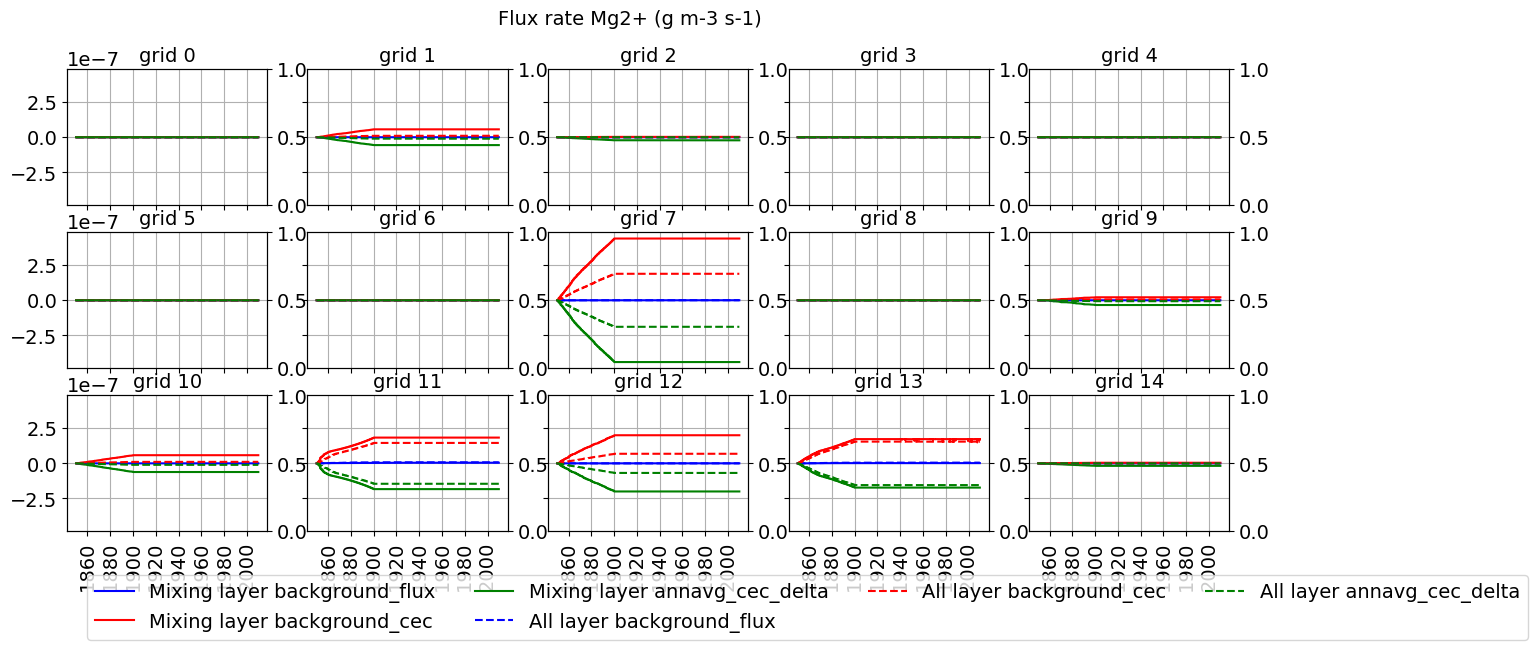

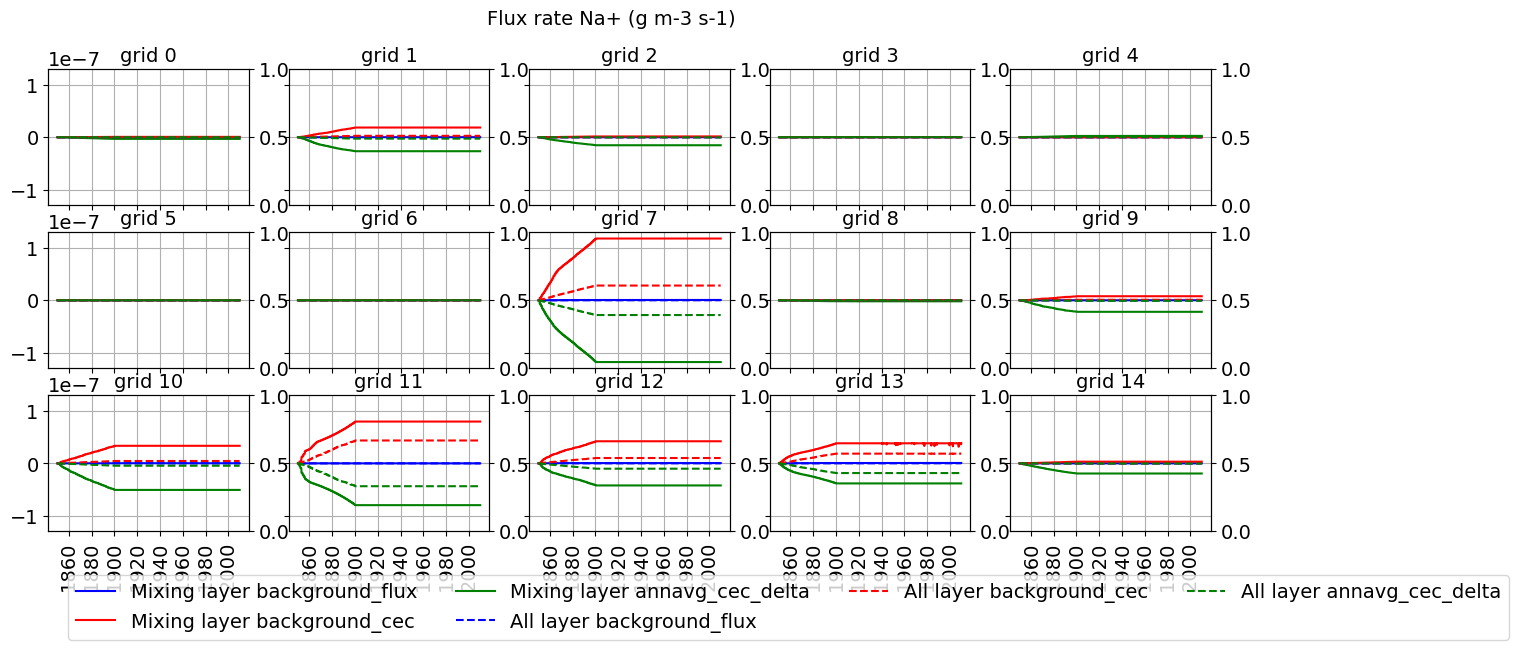

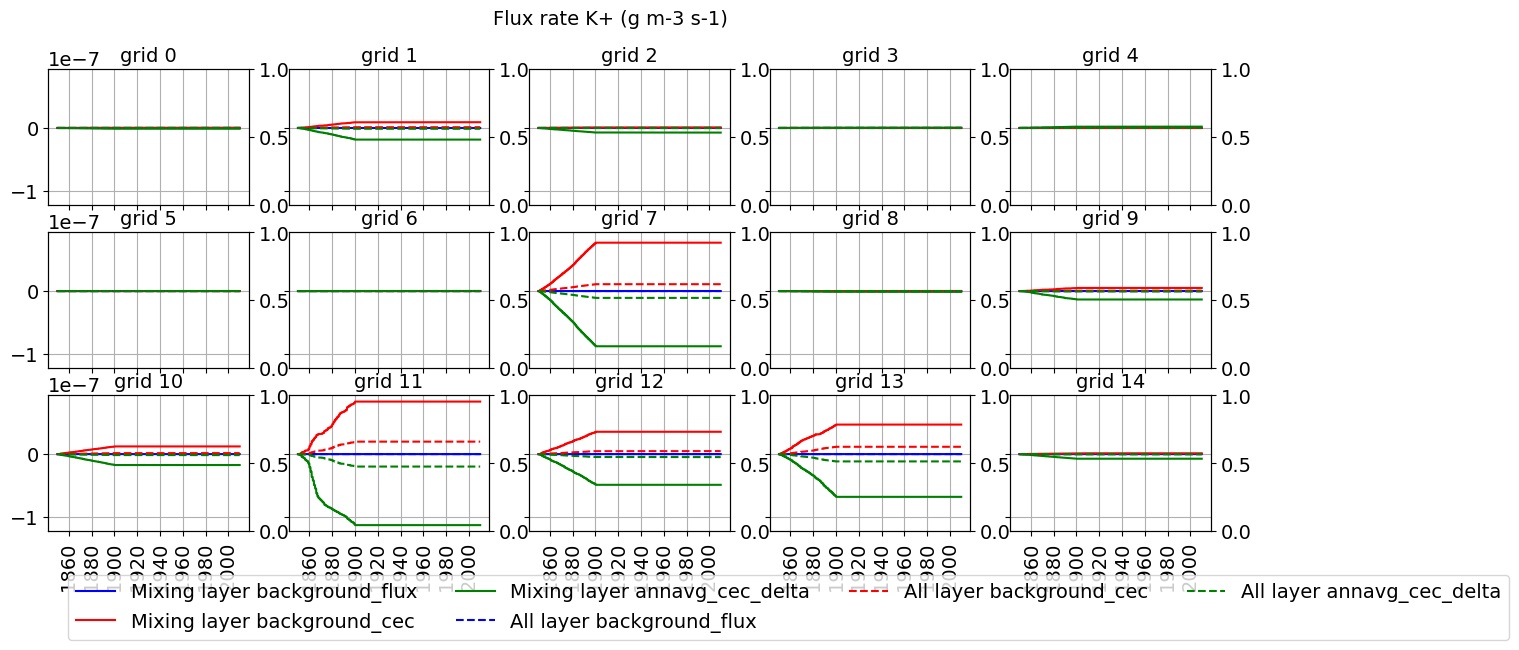

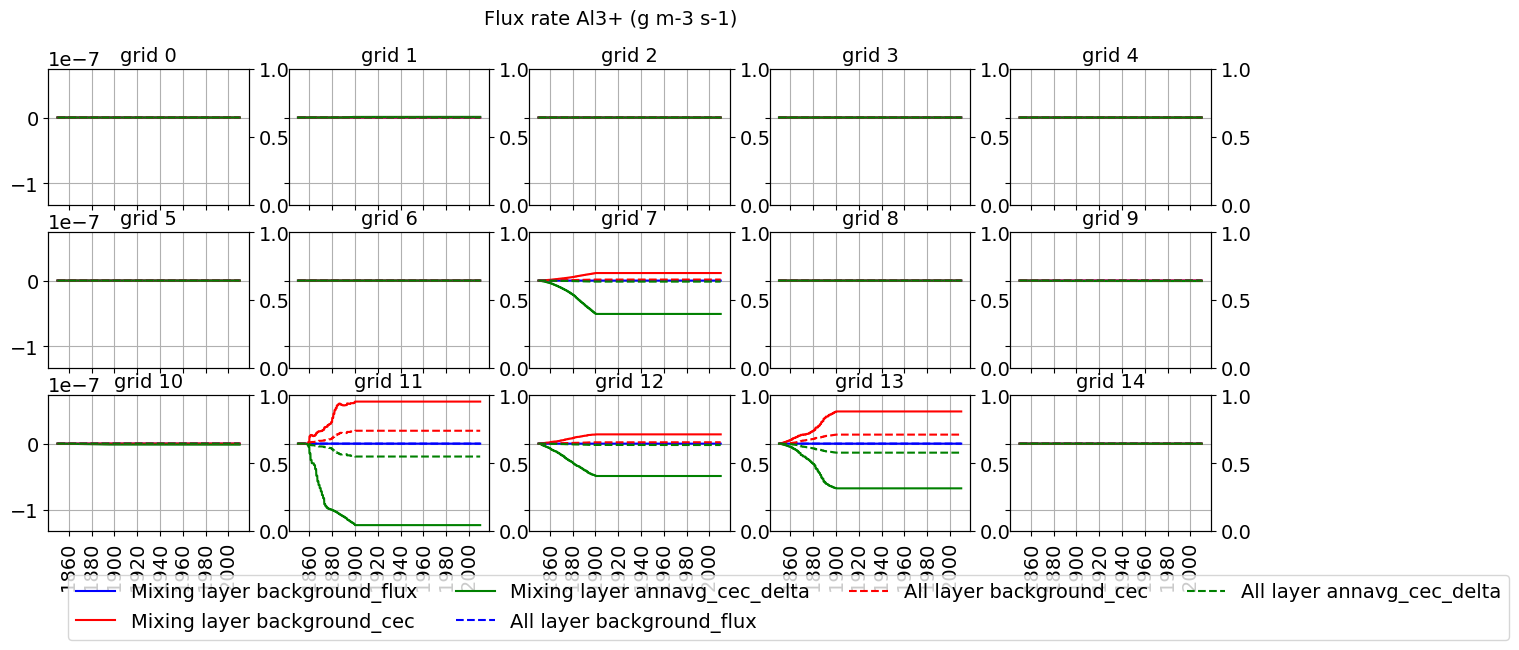

In [64]:
# plot background weathering rate and ??? on the same graph
clist = ['b', 'r', 'g']
for icat,ion in enumerate(cations):
    fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = True)
    for i, site in enumerate(site_list):
        ax = axes.flat[i]
        ax2 = ax.twinx()

        h = []
        for layer, ls in zip(['mixing_depth', 'full_depth'], ['-', '--']):
            for j, var in enumerate(flux_dict.keys()):
                htemp, = ax.plot(flux_dict[var].index, flux_dict[var][(ion,layer,site)],
                                 color = clist[j], ls = ls)
                h.append(htemp)

        ax.set_title(site)
        # ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
        plt.setp(ax.get_xticklabels(), rotation = 90)
        ax.grid(True)
        # ax.set_xlim([pd.Timestamp('2003-01-01'), pd.Timestamp('2003-12-31')])

    ax.legend(h, [f'{m} {n}' for m in ['Mixing layer', 'All layer'] \
               for n in flux_dict.keys()],
              loc = [-4.7, -0.8], ncol = 4)
    fig.suptitle(f'Flux rate {ion} (g m-3 s-1)', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_cation_flux_{icat}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

## 2.5 Flux limit on cation exchange and solutes

In [65]:
flux_dict = {}
for var in ['cec_limit', 'flux_limit']:
    flux_dict[var] = \
        pd.DataFrame(np.nan, index = tvec_mon,
                    columns = pd.MultiIndex.from_product([cations, ['mixing_depth', 'full_depth'],
                                                        site_list]))
hr = xr.open_mfdataset(file_list)
for i in range(len(cations)):
    for var in flux_dict.keys():
        temp = hr[f'{var}_vr_{i+1}'][:, :10, :].resample(time = '1M').mean().values

        temp1 = np.sum(temp * dzsoi.reshape(1, -1, 1), axis = 1) / np.sum(dzsoi)
        flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1

        temp2 = np.sum(temp[:, :6] * dzsoi[:6].reshape(1, -1, 1), axis = 1) / np.sum(dzsoi[:6])
        flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
hr.close()

/tmp/ipykernel_1323541/3975777008.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3975777008.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/3975777008.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3975777008.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2


/tmp/ipykernel_1323541/3975777008.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3975777008.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/3975777008.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3975777008.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'mixing_depth')] = temp2
/tmp/ipykernel_1323541/3975777008.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:, (cations[i],'full_depth')] = temp1
/tmp/ipykernel_1323541/3975777008.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  flux_dict[var].loc[:,

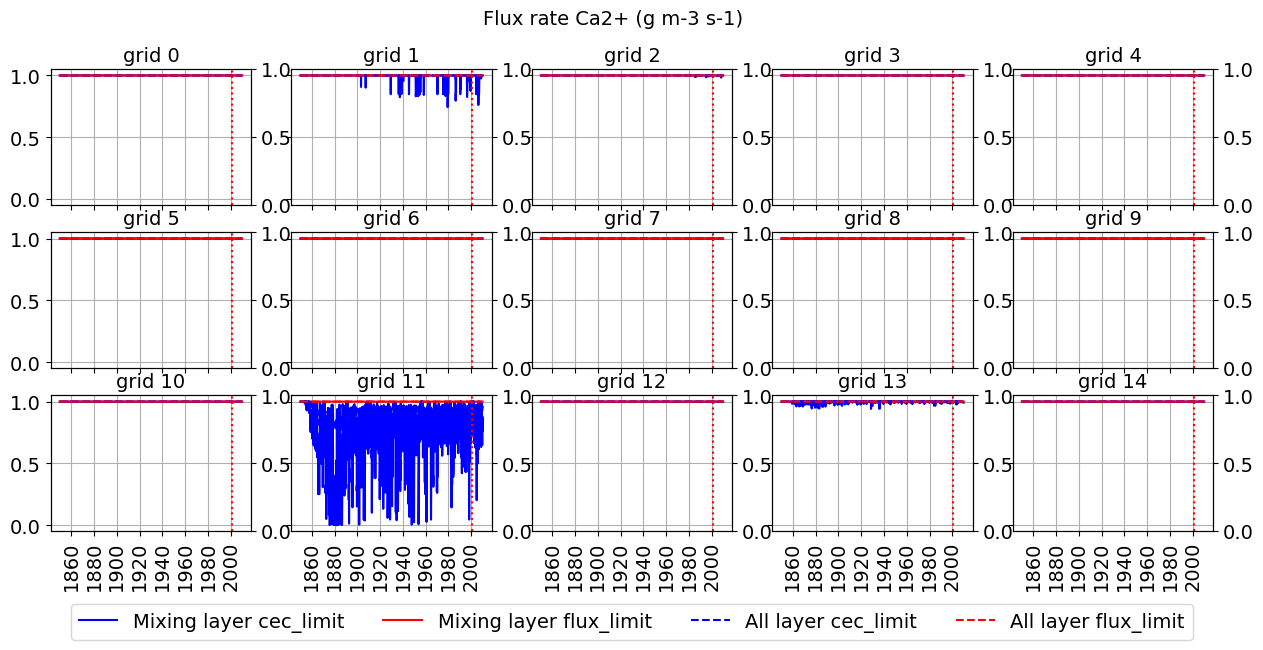

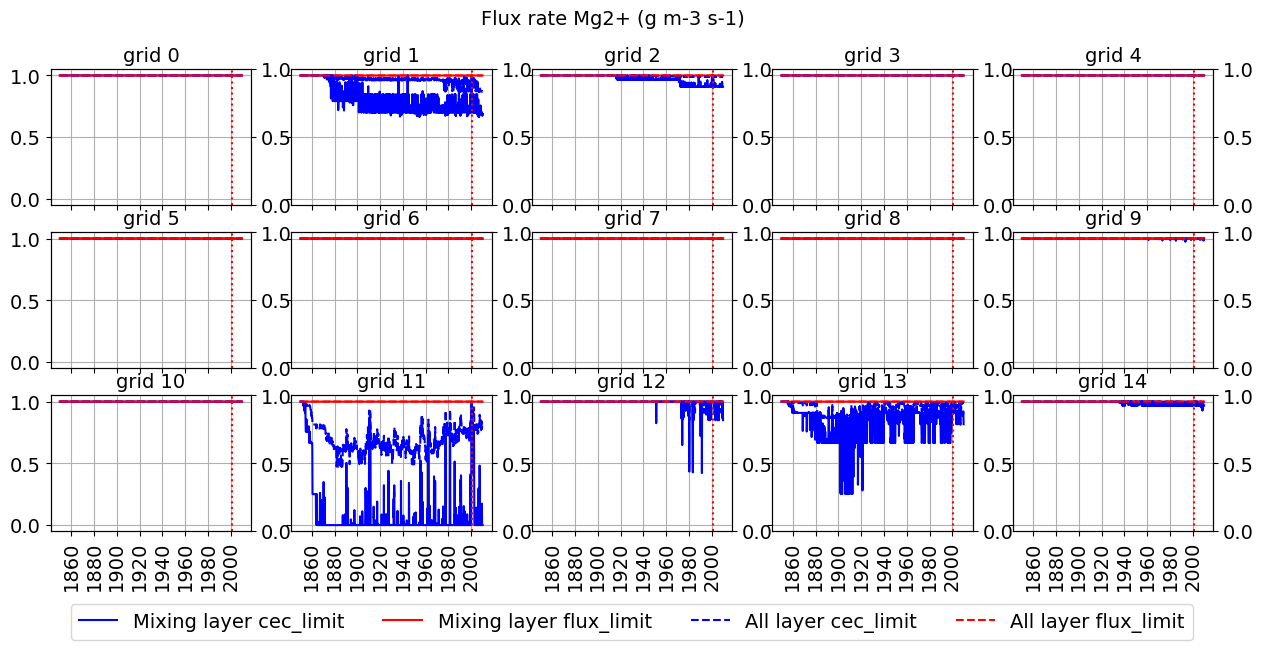

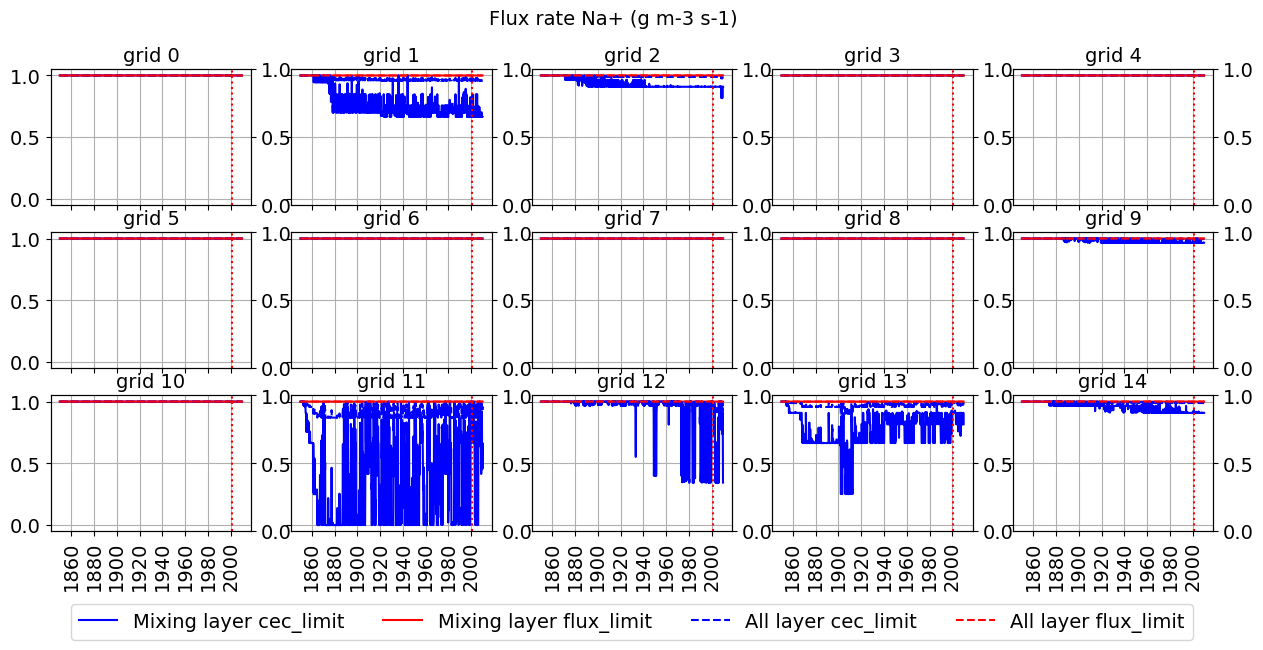

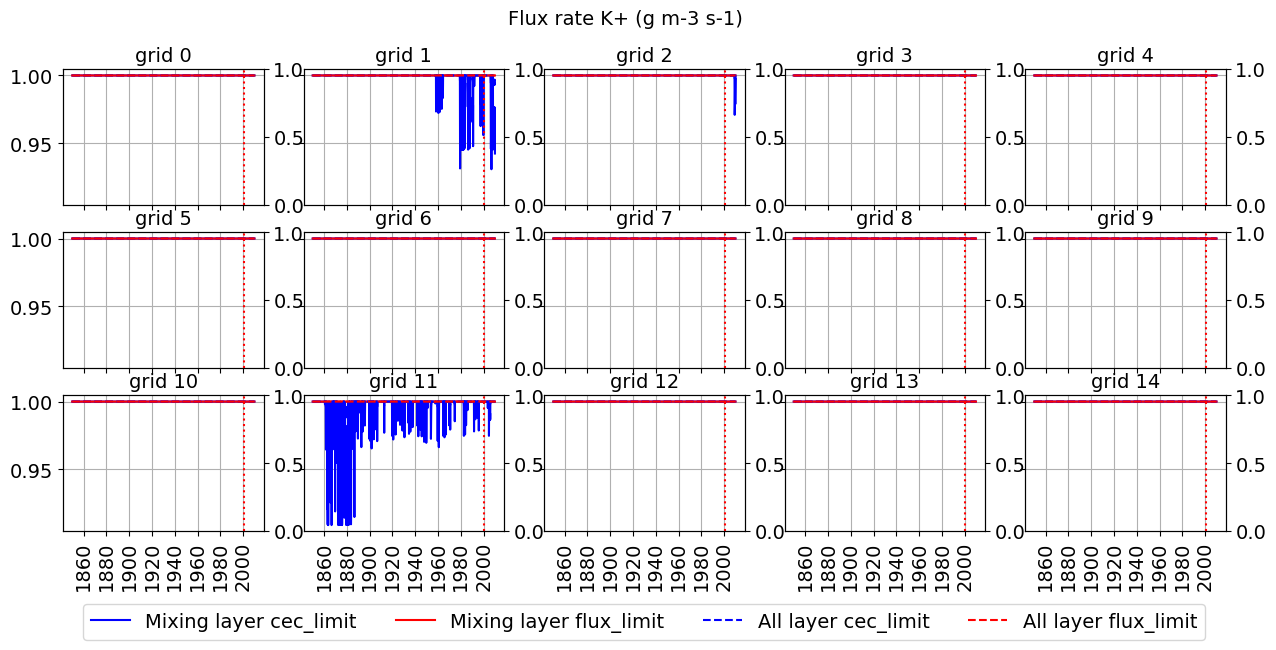

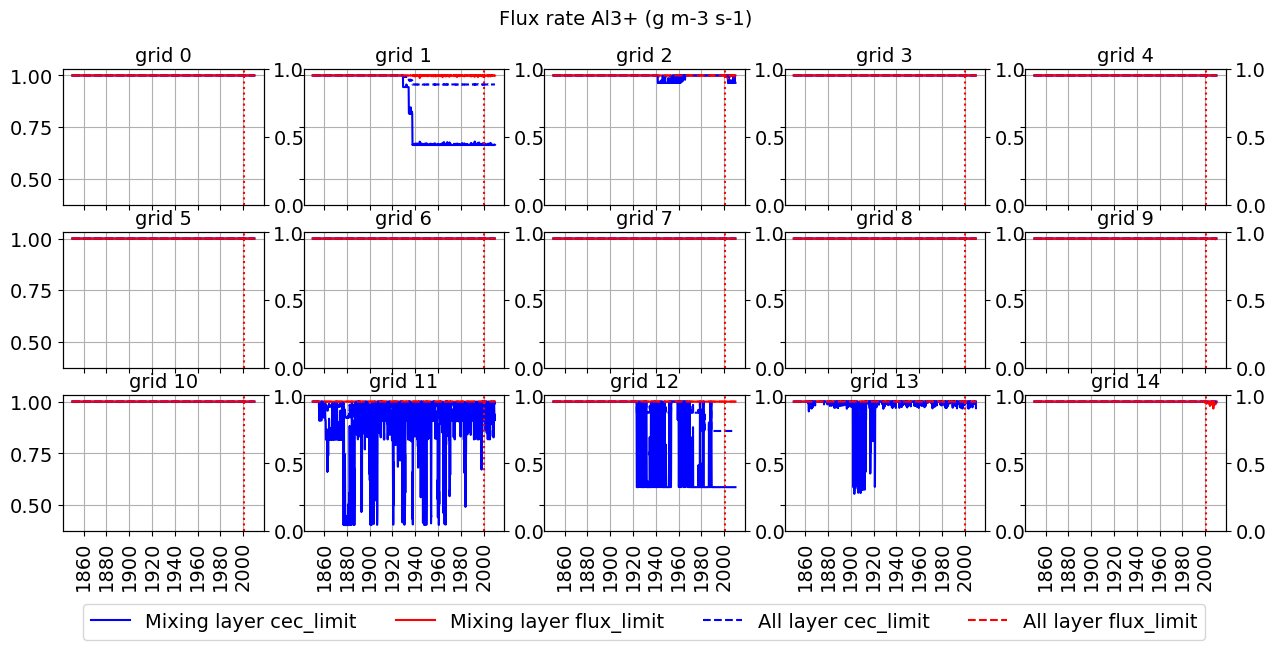

In [66]:
# plot background weathering rate and ??? on the same graph
clist = ['b', 'r', 'g']
for icat,ion in enumerate(cations):
    fig, axes = plt.subplots(3, 5, figsize = (15, 6), sharex = True, sharey = True)
    for i, site in enumerate(site_list):
        ax = axes.flat[i]
        ax2 = ax.twinx()

        h = []
        for layer, ls in zip(['mixing_depth', 'full_depth'], ['-', '--']):
            for j, var in enumerate(flux_dict.keys()):
                htemp, = ax.plot(flux_dict[var].index, flux_dict[var][(ion,layer,site)],
                                 color = clist[j], ls = ls)
                h.append(htemp)

        ax.set_title(site)
        ax.axvline(pd.Timestamp('2000-09-01'), color = 'r', ls = ':')
        plt.setp(ax.get_xticklabels(), rotation = 90)
        ax.grid(True)
        # ax.set_xlim([pd.Timestamp('2003-01-01'), pd.Timestamp('2003-12-31')])

    ax.legend(h, [f'{m} {n}' for m in ['Mixing layer', 'All layer'] \
               for n in flux_dict.keys()],
              loc = [-4.7, -0.8], ncol = 4)
    fig.suptitle(f'Flux rate {ion} (g m-3 s-1)', fontsize = 14)
    plt.savefig(os.path.join(path_out, f'compare_flux_limit_{icat}.png'), 
                dpi = 600., bbox_inches = 'tight')
    #plt.close()

## 2.6 Secondary mineral formation